In [2]:
import requests
import json
import urllib
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame as pd

In [3]:
# ip = "192.168.0.114"
ip = "127.0.0.1"
port = "5000"
query = "http://{}:{}/health".format(ip, port)
r = requests.get(query)
json.loads(r.text)

{'success': True}

In [5]:
import pandas

query = "http://{}:{}/getStock/MSFT".format(ip, port)
r = requests.get(query)
inp = json.loads(r.text)
df = pd.from_dict(inp)

tmp = df.to_json()
df = pandas.read_json(tmp)
df = df.sort_values(by='date')
df.head()

,adjusted_close,close,date,dividend_amount,high,id,low,open,split_coefficient,symbol,volume
5411,10.6408,131.13,1998-01-02,0.0,131.50,MSFT1998-01-02,129.50,129.63,1,MSFT,4968500
5410,10.5799,130.38,1998-01-05,0.0,133.63,MSFT1998-01-05,127.87,131.25,1,MSFT,10047200
5409,10.6408,131.13,1998-01-06,0.0,133.00,MSFT1998-01-06,129.25,129.75,1,MSFT,8479300
5408,10.5134,129.56,1998-01-07,0.0,131.19,MSFT1998-01-07,127.50,129.88,1,MSFT,7686600
5407,10.5897,130.50,1998-01-08,0.0,132.13,MSFT1998-01-08,127.50,128.63,1,MSFT,9702400


In [6]:
# Target value - i days into the future
days_into_future_target = 2
target = (df["adjusted_close"].shift(-days_into_future_target) - df["adjusted_close"]) / df["adjusted_close"]
targetBin = target.map(lambda x: x>0)

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin

class stockTransformer(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        print("Fit")
        return self

    def _meaning(self, x):
        return(True)

    def transform(self, tmp, y=None):
        print("Transform")
        #Vi tittar tillbaka {i} dagar
        try:
            for j in [1,2,3,5,7,10]: #range(1, 10):
                for c in ["adjusted_close", "high", "low", "open", "volume"]: #"close", 
                    tmp["hist_{}_{}".format(c,j)] = (tmp[c].shift(j) - tmp[c]) / tmp[c]

            # Date -> month / day
            tmp.date = tmp.date.astype(str)
            tmp["month"] = tmp["date"].apply(lambda x : str(x).split("-")[1])
            tmp["day"] = tmp["date"].apply(lambda x : str(x).split("-")[2])

            tmp = tmp.drop(["adjusted_close", "close", "date", "dividend_amount", "high", "id", "low", "open", "split_coefficient", "symbol", "volume"], axis=1)
            r = tmp.fillna(-1)  # TODO - ta bort NaN från både X/Y
            return r
        except Exception as e:
            print(e)
            return None
        
    def predict(self, X, y=None):
        return(X)

    def score(self, X, y=None):
        return(sum(self.predict(X))) 

In [8]:
assert df.shape[0] == target.shape[0]

# MLflow 

In [9]:
from sklearn.model_selection import train_test_split

Y = targetBin.fillna(0) # TODO - ta bort NaN från både X/Y
X = df

x_train, x_test, y_train, y_test = train_test_split(X, Y)

In [10]:
import warnings
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

from sklearn.model_selection import train_test_split

def eval_metrics(actual, pred):
    acc = accuracy_score(actual, pred)
    f1 = f1_score(actual, pred)
    return acc, f1

warnings.filterwarnings("ignore")
np.random.seed(40)        

In [13]:
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier

import mlflow
import mlflow.sklearn

mname = "RandomForestClassifier"

mlflow.set_experiment("StockClass")

with mlflow.start_run(experiment_id=1, run_name=mname):
    clf = RandomForestClassifier()
    lr = Pipeline([('customTransformer', stockTransformer()), (mname, clf)])
    lr.fit(x_train, y_train)

    # Evaluate Metrics
    pred = lr.predict(x_test)
    (acc, f1) = eval_metrics(y_test, pred)

    # Print out metrics
    print("{} model - ".format(mname))
    print("  ACC: %s" % acc)
    print("  F1: %s" % f1)
    
    # Log parameter, metrics, and model to MLflow
#     mlflow.log_param("alpha", alpha)
#     mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_metric("ACC", acc)
    mlflow.log_metric("F1", f1)
    mlflow.log_metric("Days-into-future", days_into_future_target)
    mlflow.set_tag("model", mname)

#         mlflow.set_experiment("s")
    lr.predict = lr.predict_proba
    mlflow.sklearn.log_model(lr, "model")

Fit
Transform
Transform
RandomForestClassifier model - 
  ACC: 0.50406504065
  F1: 0.456680161943


Transform


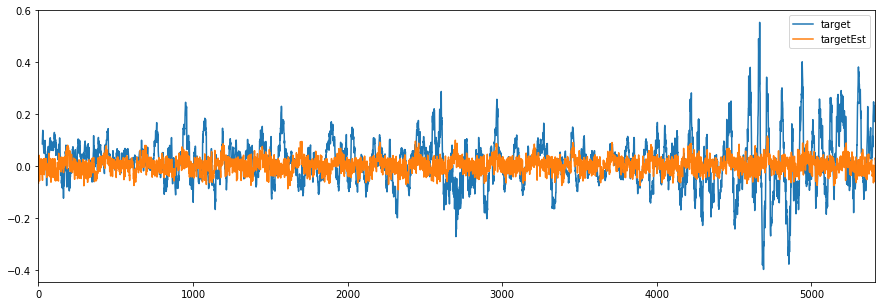

In [25]:
c = pandas.DataFrame()
c["target"] = target
c["targetEst"] = lr.predict(df)
c.plot(figsize=(15,5))
plt.show()